In [14]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from alphatoe.interpretability import numpy
from alphatoe import plot, game, evals, interpretability
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
n_epochs = 1000
epochs = [x for x in range(n_epochs) if x % 10 == 0 or x == n_epochs - 1]

chkpts = [interpretability.load_model(
    f"../scripts/models/prob all 8 layer control with checkpoints-20250708-002411-epoch{x}"
) for x in epochs]

model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control with checkpoints-20250708-002411"
)

chkpts = [(x, y) for x, y in zip(epochs, chkpts)]

In [15]:
# First, let's extract the data for all epochs
def get_projection_data(model, seq_fwd):
    """Extract W_Q and compute projection for a given model checkpoint"""
    pos_emb = model.pos_embed(seq_fwd, 0)[0]  # positional embedding (10, 128)
    W_Q = model.W_Q[0, 1]  # Head index 1 (128, 16)
    
    # Compute SVD
    U, S, V = np.linalg.svd(numpy(W_Q))
    
    # Project positional embeddings onto first singular vector
    Q_proj = numpy(pos_emb) @ U[:, :1]
    
    # Convert to list of values
    Q_proj = Q_proj.flatten().tolist()
    
    return Q_proj

In [16]:
# Prepare sequence
seq_fwd = torch.tensor([[10, 0, 1, 2, 3, 4, 5, 7, 8, 6]])

# Get projections for all checkpoints
all_projections = []
for epoch, checkpoint in chkpts:
    proj = get_projection_data(checkpoint, seq_fwd)
    all_projections.append((epoch, proj))

# Also get projection for final model
final_proj = get_projection_data(model, seq_fwd)
all_projections.append((n_epochs, final_proj))

/Users/omarayyub/p/Alphatoe/.venv/lib/python3.11/site-packages/matplotlib/animation.py:884: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


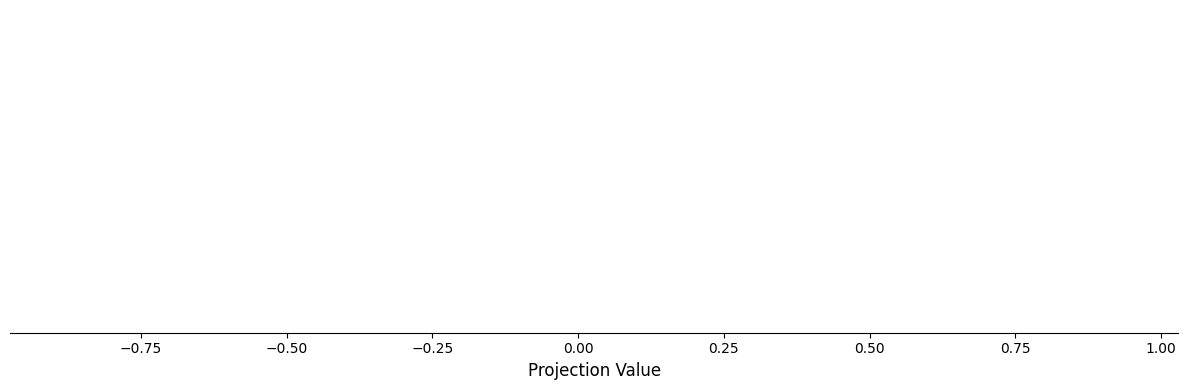

In [23]:
# Create the animation
fig, ax = plt.subplots(figsize=(12, 4))

# Set up the plot limits based on all data
all_values = [val for _, proj in all_projections for val in proj]
x_margin = 0.1 * (max(all_values) - min(all_values))
ax.set_xlim(min(all_values) - x_margin, max(all_values) + x_margin)
ax.set_ylim(-20, 20)

# Remove y-axis and spines
ax.yaxis.set_visible(False)
for spine in ['left', 'top', 'right']:
    ax.spines[spine].set_visible(False)

# Set labels
ax.set_xlabel('Projection Value', fontsize=12)

# Initialize plot elements
line, = ax.plot([], [], 'b-', linewidth=2)
points, = ax.plot([], [], 'bo', markersize=10)
annotations = []
epoch_text = ax.text(0.02, 0.98, '', transform=ax.transAxes, 
                     fontsize=14, fontweight='bold', va='top')

def init():
    """Initialize animation"""
    line.set_data([], [])
    points.set_data([], [])
    for ann in annotations:
        ann.remove()
    annotations.clear()
    epoch_text.set_text('')
    return line, points, epoch_text

def animate(frame):
    """Update animation for each frame"""
    epoch, proj_values = all_projections[frame]
    
    # Create position-value pairs
    positions = list(range(10))
    
    # Update line and points
    line.set_data(proj_values, [0]*len(proj_values))
    points.set_data(proj_values, [0]*len(proj_values))
    
    # Clear previous annotations
    for ann in annotations:
        ann.remove()
    annotations.clear()
    
    # Add new annotations
    for i, (pos, val) in enumerate(zip(positions, proj_values)):
        if i % 2 == 0:
            y_pos = 10
            va = 'bottom'
        else:
            y_pos = -10
            va = 'top'
        
        ann = ax.annotate(f'Pos {pos}', (val, 0), 
                         xytext=(0, y_pos), 
                         textcoords='offset points',
                         ha='center', va=va,
                         rotation=45, 
                         rotation_mode='anchor',
                         fontsize=10)
        annotations.append(ann)
    
    # Update epoch text
    epoch_text.set_text(f'Epoch: {epoch}')
    
    # Update title
    ax.set_title('Projection of Positional Embeddings onto First Singular Vector of W_Q', 
                 fontsize=14, pad=20)
    
    return line, points, epoch_text, *annotations

# Create animation
anim = FuncAnimation(fig, animate, init_func=init, 
                    frames=len(all_projections), 
                    interval=200,  # 200ms between frames
                    repeat=True,
                    blit=False)

# Show the animation
plt.tight_layout()
plt.show()

# Save the animation as a GIF
anim.save('projection_animation.gif', writer='pillow', fps=5)